In [35]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,r2_score

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [36]:
df = pd.read_csv('AmesHousing.csv')
data = df.drop(['PID'], axis=1)

In [37]:
data = data.rename(columns={"MS SubClass": "MSSubClass", "MS Zoning": "MSZoning",'Lot Frontage':'LotFrontage', 'Lot Area':'LotArea',
       'Sale Condition':'SaleCondition','Yr Sold':'YrSold','YearBuilt': 'YearBuilt', 'Gr Liv Area': 'GrLivArea', 'Garage Area':'GarageArea',
       'Year Built':'YearBuilt','Pool Area':'PoolArea','Year Remod/Add':'YearRemodAdd','Garage Cars':'GarageCars','Total Bsmt SF':"TotalBsmtSF",
       "Full Bath":"FullBath","Mas Vnr Area":"MasVnrArea","1st Flr SF":"1stFlrSF","Garage Yr Blt":"GarageYrBlt","TotRms AbvGrd":"TotRmsAbvGrd"
})

In [38]:
liste_to_numeric = ['YrSold', 'YearBuilt', 'GrLivArea', 'LotFrontage', 'LotArea','GarageArea']
data[liste_to_numeric] = data[liste_to_numeric].apply(pd.to_numeric)

In [39]:
data = data*1

Data cleaning

In [40]:
# create dumies
data['Fence'] = data['Fence'].notna()
data['Pool'] = data['PoolArea'] > 0

# create the new variable 'age'
data['Age'] = data.apply(lambda x: x['YrSold']-x['YearBuilt'] if (x['YearBuilt']<x['YearRemodAdd']) 
                                                           else (x['YrSold']-x['YearRemodAdd']), axis=1)

# Delete all data with MSZoning = commercial, agriculture and industrial as these are not residential units
data = data[(data.MSZoning != 'C (all)') & (data.MSZoning != 'I (all)') & (data.MSZoning != 'A (agr)')]

# Delete abnormal sales
data = data[(data.SaleCondition != 'Abnorml')] 
data = data[(data.SaleCondition != 'Family')] 

In [41]:
df =data.corr().abs()
df =df[['SalePrice']]
df1 =df[df < 1]
df2 = df1[df1>0.5]
df3 = df2.stack()
print(df3.sort_values(ascending=False))

Overall Qual  SalePrice    0.800321
GrLivArea     SalePrice    0.712332
GarageCars    SalePrice    0.652299
GarageArea    SalePrice    0.649312
TotalBsmtSF   SalePrice    0.632793
1stFlrSF      SalePrice    0.624723
Age           SalePrice    0.548871
YearBuilt     SalePrice    0.548422
FullBath      SalePrice    0.541720
GarageYrBlt   SalePrice    0.522939
MasVnrArea    SalePrice    0.521908
YearRemodAdd  SalePrice    0.520682
TotRmsAbvGrd  SalePrice    0.509662
dtype: float64


In [42]:
#comme GarageCars et GarageArea sont coréllées on ne gardera que GarageCars (plus forte corrélation)
#comme TotalBsmtSF et 1stFlrSF sont coréllées on ne gardera que TotalBsmtSF (plus forte corrélation)
#comme TotRmsAbvGrd and GrLivArea sont coréllées on ne gardera que GrLivArea (plus forte corrélation)
#OverallQual est une variable subjective (notation du bien par les agents immobiliers) elle est donc naturellement corréllée avec toutes les autres.
#age a été créée a partir de YrSold, YearBuiltet YearRemodAdd , on en garde qu'elle

columns_to_keep=["LotArea","LotFrontage","GrLivArea","GarageCars","GarageArea","TotalBsmtSF","YearBuilt","1stFlrSF","Age","FullBath","MasVnrArea","GarageYrBlt","TotRmsAbvGrd"]

In [43]:
# Select Features
# X_train = data[['Age','GrLivArea', 'LotFrontage', 'LotArea', 'GarageArea', 'Fence', 'Pool']]
X = data[columns_to_keep]
Y = data[['SalePrice']]

In [44]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=.3, random_state=1121218)

entrainement du model

In [45]:
numerical_features = X_train.select_dtypes(include='number').columns.tolist()
categorical_features = X_train.select_dtypes(exclude='number').columns.tolist()

In [46]:
numeric_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', MinMaxScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

In [47]:
from sklearn.compose import ColumnTransformer

full_processor = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numerical_features),
    ('category', categorical_pipeline, categorical_features)
])

In [48]:
randomf = RandomForestRegressor()

randomf_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', randomf)
])

In [49]:
from sklearn.model_selection import GridSearchCV

param_dict = {'model__n_estimators': [150,200,250,300], 'model__bootstrap': [True,False]}

search = GridSearchCV(randomf_pipeline, param_dict, 
                      cv=5, 
                      scoring='neg_mean_absolute_error')

_ = search.fit(X_train, y_train)

print('Best score:', abs(search.best_score_))
print('Best params:', search.best_params_)


C:\Users\marie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\marie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\marie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\marie\AppData\Local\Programs\Python\Python310\lib\site-

Best score: 19689.189674369693
Best params: {'model__bootstrap': True, 'model__n_estimators': 300}


In [57]:
import pickle
filename = 'last_model.sav'
pickle.dump(search, open(filename, 'wb'))

Evaluation du modele

In [59]:
last_model = pickle.load(open("last_model.sav", 'rb'))

In [60]:
last_model.best_score_

-19689.189674369693

In [61]:
predict_on_Xtrain = last_model.predict(X_train)
predict_on_Xvalid = last_model.predict(X_valid)

In [62]:
mae_train = mean_absolute_error(y_train,predict_on_Xtrain)
mae_valid = mean_absolute_error(y_valid,predict_on_Xvalid)

In [63]:
print("EVALUATION DU MODELE GRACE A LA MAE (Mean Absolute Error)")
print("    ")
print("SUR LES DONNEES D'ENTRAINEMENT:")
print("Le modèle prédit une valeur exacte avec une erreure moyenne de {}$, ce qui est un delta acceptable sur le prix d'un bien immobilier".format(round(mae_train)))
print("    ")
print("SUR LES DONNEES DE VALIDATION:")
print("Le modèle prédit une valeur exacte et ce avec une erreure moyenne de {}$, ce qui n'est plus acceptable".format(round(mae_valid)))
print("    ")
print("CONCLUSION:")
print("l'écart de performance des predictions est trop imortant,")
print("celui ci est bien plus performant sur les données d'entrainement que sur les données de validation")
print("on constate un overfitting du model")

EVALUATION DU MODELE GRACE A LA MAE (Mean Absolute Error)
    
SUR LES DONNEES D'ENTRAINEMENT:
Le modèle prédit une valeur exacte avec une erreure moyenne de 7134$, ce qui est un delta acceptable sur le prix d'un bien immobilier
    
SUR LES DONNEES DE VALIDATION:
Le modèle prédit une valeur exacte et ce avec une erreure moyenne de 20187$, ce qui n'est plus acceptable
    
CONCLUSION:
l'écart de performance des predictions est trop imortant,
celui ci est bien plus performant sur les données d'entrainement que sur les données de validation
on constate un overfitting du model


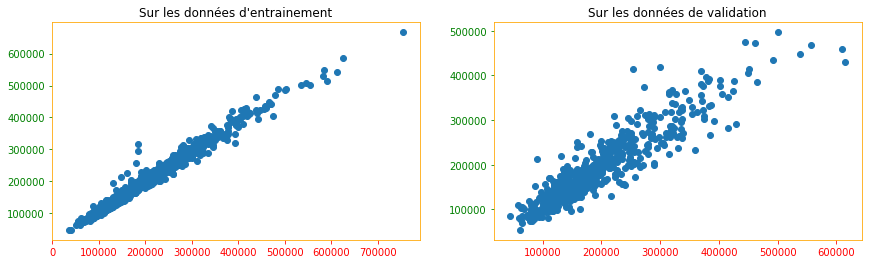

In [56]:
with plt.rc_context({'axes.edgecolor':'orange', 'xtick.color':'red', 'ytick.color':'green', 'figure.facecolor':'white'}):
    fig, (ax1, ax2) = plt.subplots(1,2)
    plt.subplots_adjust(right=2)

    ax1.scatter(y_train,predict_on_Xtrain)
    ax1.set_title("Sur les données d'entrainement")

    ax2.scatter(y_valid,predict_on_Xvalid)
    ax2.set_title("Sur les données de validation")